# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [50]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [51]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [52]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [53]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [54]:
# Loading the dataset
# eg.
dirpath = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32, 3)


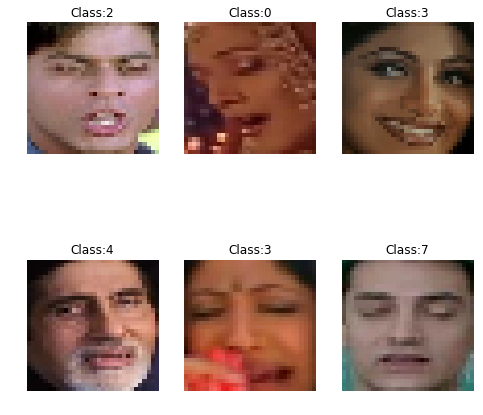

In [55]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [56]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [57]:
imfdb_keylist = []
imfdb_valuelist = []
for key, item in imfdb_dict.items():
    imfdb_keylist.append(key)
    imfdb_valuelist.append(item)

cfw_keylist = []
cfw_valuelist = []
for key, item in cfw_dict.items():
    cfw_keylist.append(key)
    cfw_valuelist.append(item)
    


In [58]:
# Loading the dataset
# eg.
dirpath = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/IMFDB/'
X_IMFDB,y_IMFDB = load_data(dirpath)
N,H,W = X_IMFDB.shape[0:3]
C = 1 if opt['is_grayscale'] else X_IMFDB.shape[3]
X_IMFDB = X_IMFDB.reshape((N,H*W*C))

dirpath = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/IIIT-CFW/'
X_CFW,y_CFW = load_data(dirpath)
N,H,W = X_CFW.shape[0:3]
C = 1 if opt['is_grayscale'] else X_CFW.shape[3]
X_CFW = X_CFW.reshape((N,H*W*C))


dirpath = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/Yale_face_database/'
X_YALE,y_YALE = load_data(dirpath)
N,H,W = X_YALE.shape[0:3]
C = 1 if opt['is_grayscale'] else X_YALE.shape[3]
X_YALE = X_YALE.reshape((N,H*W*C))

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [59]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components = k)
    X_pca = pca.fit_transform(X)
    X_reconstruct = pca.inverse_transform(X_pca)
    
    return X_pca,X_reconstruct

def get_pca_var_thresold(X):
    pca = PCA()
    pca.fit_transform(X)
    variance = pca.explained_variance_
    variance_sum = pca.explained_variance_ratio_.cumsum()
    
    for i in range(variance_sum.shape[0]):
        if variance_sum[i] >= 0.9:
            thresold = i
            break
    return thresold, variance

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [60]:
def get_kernel_pca(X, k,kernel='rbf'):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,fit_inverse_transform = True)
    kpca.fit(X)
    X_k = kpca.transform(X)
    X_reconstruct = kpca.inverse_transform(X_k)
    return X_k,X_reconstruct

X_IMFDB_pca, X_IMFDB_reconstruct = get_kernel_pca(X_IMFDB, 30,kernel='rbf')
X_IMFDB_pca, X_IMFDB_reconstruct = get_kernel_pca(X_IMFDB, 30,kernel='rbf')

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [61]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    lda.fit(X,y)
    X_k = lda.transform(X)
    return X_k


### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [62]:
def get_kernel_lda(X,y,k,kernel='rbf'):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [63]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

dirpath_YALE = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/Yale_face_database/'
dirpath_CFW = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/IIIT-CFW/'
dirpath_IMFDB = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/IMFDB/'

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [64]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features


# Questions

1(a). What are eigen faces? 

___________________________

a) Eigen faces are ﬁrst few eigen vectors which are good enough to represent the original image and reconstructed image from those few eigen vectors will be sufﬁcient enough to
identify the actual face. This is being done to reduce the image dimension to make calculation and model learning less complex.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

b) Each Dataset (and their respective actors/politician/person) has different number of eigen faces , which are able to capture 90% of the original image.
In average, IMFDB IIIT CFW dataset, number of eigen faces are in range of 20-35
In average, IIIT CFW dataset, number of eigen faces are in range of 30-50
In average, Yale dataset, number of eigen faces are in range of 4-6

Exact number of eigen faces for each set of persons are calculated below in code.

In [65]:
# Compute your features 
X_IMFDB_PCA3D , _ = get_pca(X_IMFDB,30)
X_IMFDB_kPCA3D , _ = get_kernel_pca(X_IMFDB, 30,kernel='rbf')
X_IMFDB_LDA3D = get_lda(X_IMFDB,y_IMFDB,30)
X_IMFDB_kLDA3D = get_kernel_lda(X_IMFDB,y_IMFDB,30,kernel='rbf')
X_IMFDB_resnet = get_resnet_features(dirpath_IMFDB)
X_IMFDB_vgg = get_vgg_features(dirpath_IMFDB)

# Compute your features 
X_CFW_PCA3D , _ = get_pca(X_CFW,40)
X_CFW_kPCA3D , _ = get_kernel_pca(X_CFW, 40,kernel='rbf')
X_CFW_LDA3D = get_lda(X_CFW,y_CFW,40)
X_CFW_kLDA3D = get_kernel_lda(X_CFW,y_CFW,40,kernel='rbf')
X_CFW_resnet = get_resnet_features(dirpath_CFW)
X_CFW_vgg = get_vgg_features(dirpath_CFW)

# Compute your features 
X_YALE_PCA3D , _ = get_pca(X_YALE,6)
X_YALE_kPCA3D , _ = get_kernel_pca(X_YALE, 6,kernel='rbf')
X_YALE_LDA3D = get_lda(X_YALE,y_YALE,6)
X_YALE_kLDA3D = get_kernel_lda(X_YALE,y_YALE,6,kernel='rbf')
X_YALE_resnet = get_resnet_features(dirpath_YALE)
X_YALE_vgg = get_vgg_features(dirpath_YALE)


C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


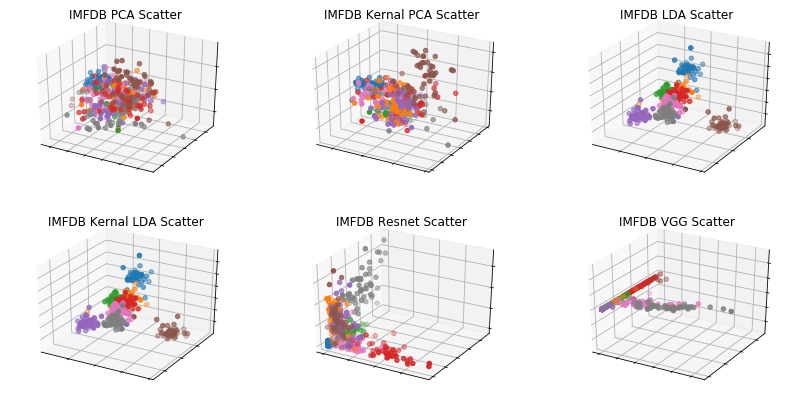

In [66]:
# Create a scatter plot  

title_list = ['IMFDB PCA Scatter','IMFDB Kernal PCA Scatter','IMFDB LDA Scatter','IMFDB Kernal LDA Scatter','IMFDB Resnet Scatter','IMFDB VGG Scatter']
IMFDB_data = [X_IMFDB_PCA3D,X_IMFDB_kPCA3D,X_IMFDB_LDA3D,X_IMFDB_kLDA3D,X_IMFDB_resnet,X_IMFDB_vgg]
subplot_ind = [231,232,233,234,235,236]

fig = plt.figure(figsize=(14,7))

for i in range(6):
    ax = fig.add_subplot(subplot_ind[i], projection='3d')
    ax.set_title(title_list[i])
    for t in range(8):
        data = IMFDB_data[i][np.where(y_IMFDB==t)]
        ax.scatter3D(data[:,0],data[:,1],data[:,2], cmap='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])


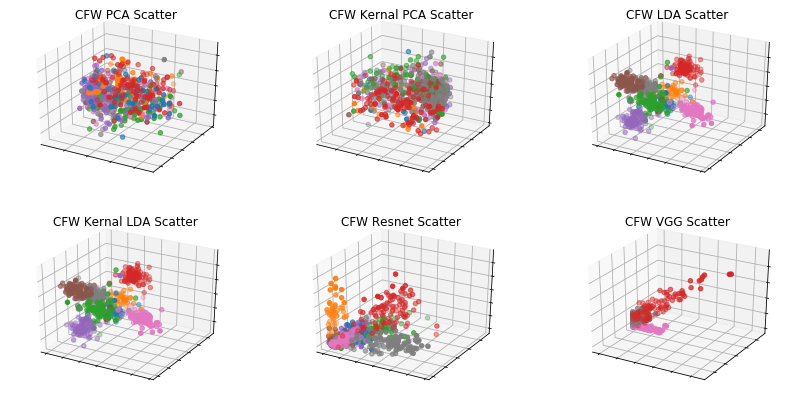

In [67]:
title_list = ['CFW PCA Scatter','CFW Kernal PCA Scatter','CFW LDA Scatter','CFW Kernal LDA Scatter','CFW Resnet Scatter','CFW VGG Scatter']
CFW_data = [X_CFW_PCA3D,X_CFW_kPCA3D,X_CFW_LDA3D,X_CFW_kLDA3D,X_CFW_resnet,X_CFW_vgg]
subplot_ind = [231,232,233,234,235,236]

fig = plt.figure(figsize=(14,7))

for i in range(6):
    ax = fig.add_subplot(subplot_ind[i], projection='3d')
    ax.set_title(title_list[i])
    for t in range(8):
        data = CFW_data[i][np.where(y_CFW==t)]
        ax.scatter3D(data[:,0],data[:,1],data[:,2], cmap='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])


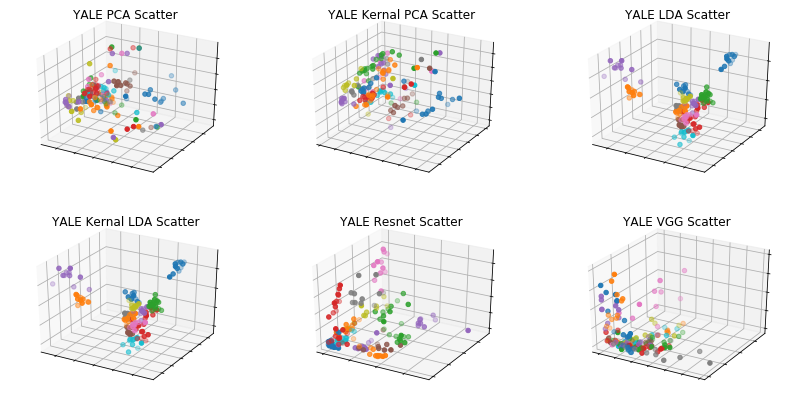

In [68]:
title_list = ['YALE PCA Scatter','YALE Kernal PCA Scatter','YALE LDA Scatter','YALE Kernal LDA Scatter','YALE Resnet Scatter','YALE VGG Scatter']
YALE_data = [X_YALE_PCA3D,X_YALE_kPCA3D,X_YALE_LDA3D,X_YALE_kLDA3D,X_YALE_resnet,X_YALE_vgg]
subplot_ind = [231,232,233,234,235,236]

fig = plt.figure(figsize=(14,7))

for i in range(6):
    ax = fig.add_subplot(subplot_ind[i], projection='3d')
    ax.set_title(title_list[i])
    for t in range(15):
        data = YALE_data[i][np.where(y_YALE==t)]
        ax.scatter3D(data[:,0],data[:,1],data[:,2], cmap='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

    

No of eigenvectors contributed to 90% of variance for MadhuriDixit is :  28
No of eigenvectors contributed to 90% of variance for Kajol is :  22
No of eigenvectors contributed to 90% of variance for SharukhKhan is :  25
No of eigenvectors contributed to 90% of variance for ShilpaShetty is :  22
No of eigenvectors contributed to 90% of variance for AmitabhBachan is :  22
No of eigenvectors contributed to 90% of variance for KatrinaKaif is :  18
No of eigenvectors contributed to 90% of variance for AkshayKumar is :  24
No of eigenvectors contributed to 90% of variance for Amir is :  20
***********************************************************************
No of eigenvectors contributed to 90% of variance for Amitabhbachan is :  24
No of eigenvectors contributed to 90% of variance for AamirKhan is :  26
No of eigenvectors contributed to 90% of variance for DwayneJohnson is :  34
No of eigenvectors contributed to 90% of variance for AishwaryaRai is :  47
No of eigenvectors contributed to 

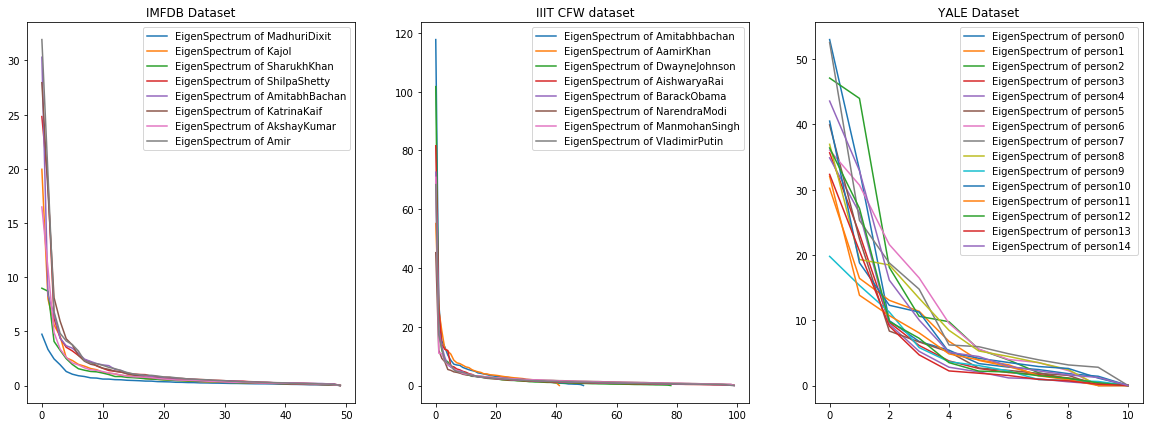

In [69]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
for i in range(8):
    data = X_IMFDB[np.where(y_IMFDB==i)]
    actor = imfdb_keylist[imfdb_valuelist.index(i)]
    k,variance = get_pca_var_thresold(data)
    plt.plot(variance[:100],label = "EigenSpectrum of {}".format(actor))
    plt.title("IMFDB Dataset")
    plt.legend()
    
    print('No of eigenvectors contributed to 90% of variance for {} is : '.format(actor),k)
print("***********************************************************************")

plt.subplot(1,3,2)
for i in range(8):
    data = X_CFW[np.where(y_CFW==i)]
    person = cfw_keylist[cfw_valuelist.index(i)]
    k,variance = get_pca_var_thresold(data)
    plt.plot(variance[:100],label = "EigenSpectrum of {}".format(person))
    plt.title("IIIT CFW dataset")
    plt.legend()
    
    print('No of eigenvectors contributed to 90% of variance for {} is : '.format(person),k)
print("***********************************************************************")    
plt.subplot(1,3,3)    
for i in range(15):
    data = X_YALE[np.where(y_YALE==i)]
    k,variance = get_pca_var_thresold(data)
    plt.plot(variance[:100],label = "EigenSpectrum of person{} ".format(i))
    plt.title("YALE Dataset")
    plt.legend()
    
    print('No of eigenvectors contributed to 90% of variance for person {} is : '.format(i),k)
print("***********************************************************************")


1(c). Reconstruct  the  image  back for each case


In [70]:
# Display results 
_ , X_IMFDB_reconstruced = get_pca(X_IMFDB,50)
_ , X_CFW_reconstruced = get_pca(X_CFW,60)
_ , X_YALE_reconstruced = get_pca(X_YALE,7)

# Show the reconstruction error
print("Reconstruction error for IMFDB using PCA",np.sqrt(np.mean((X_IMFDB - X_IMFDB_reconstruced)**2)))
print("Reconstruction error for CFW using PCA",np.sqrt(np.mean((X_CFW - X_CFW_reconstruced)**2)))
print("Reconstruction error for YALE using PCA",np.sqrt(np.mean((X_YALE - X_YALE_reconstruced)**2)))

Reconstruction error for IMFDB using PCA 0.061690671369394566
Reconstruction error for CFW using PCA 0.15719334493594608
Reconstruction error for YALE using PCA 0.14410513340696662


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


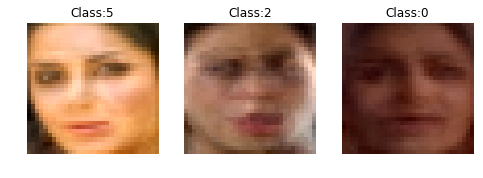

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


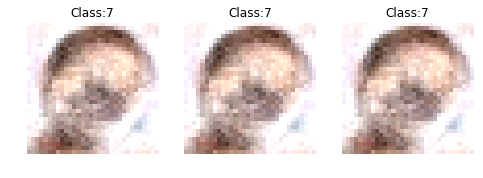

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


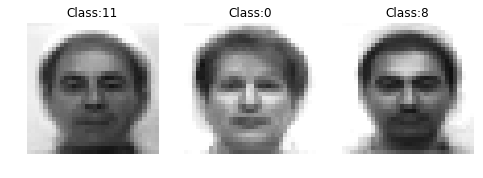

In [71]:
X_IMFDB_reconstruced = X_IMFDB_reconstruced.reshape((X_IMFDB_reconstruced.shape[0],32,32,3))
# Display random images
C = 1 if opt['is_grayscale'] else X_IMFDB_reconstruced.shape[3]
ind = np.random.randint(0,y_IMFDB.shape[0],3)
disply_images(X_IMFDB_reconstruced[ind,...],y_IMFDB[ind],row=1,col=3)

X_CFW_reconstruced = X_CFW_reconstruced.reshape((X_CFW_reconstruced.shape[0],32,32,3))

# Display random images
C = 1 if opt['is_grayscale'] else X_CFW_reconstruced.shape[3]
ind = np.random.randint(0,y_CFW.shape[0],3)
disply_images(X_CFW_reconstruced[ind,...],y_CFW[ind],row=1,col=3)

X_YALE_reconstruced = X_YALE_reconstruced.reshape((X_YALE_reconstruced.shape[0],32,32,3))
# Display random images
C = 1 if opt['is_grayscale'] else X_YALE_reconstruced.shape[3]
ind = np.random.randint(0,y_YALE.shape[0],3)
disply_images(X_YALE_reconstruced[ind,...],y_YALE[ind],row=1,col=3)



1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

From IMFDB data,Madhuri Dixit is difﬁcult to represent using fewer eigen vectors. Similarly, in CFW dataset, Narendra Modi is difﬁcult to represent using fewer eigen vectors and from YALE dataset, person 7 is is difﬁcult to represent usingfewereigenvectors. Ihavecometothisconclusion,asinprogramIhavecalculatednumberof eigen vectors needed for each star/person to represent 90% variance in their individual category.


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [72]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier:
    
    def classify(self,X_train,y_train,X_test,y_test):
        y_train = y_train.reshape(y_train.shape[0],1)
        y_test = y_test.reshape(y_test.shape[0],1)
        ip_dim = X_train.shape[1]
        model = Sequential()
        model.add(Dense(10, input_dim=ip_dim, activation='tanh'))
        model.add(Dense(10, activation='tanh'))
        model.add(Dense(15, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=200, batch_size=10,verbose=0)
        
        y_pred = model.predict_classes(X_test)
        
        return y_pred
        
        
    def confusion_matrix(self,y_pred,y_test):
        cm = confusion_matrix(y_test, y_pred) 
        acc = accuracy_score(y_test, y_pred)
        precision,recall,f_score,_ = precision_recall_fscore_support(y_test, y_pred)
        
        return cm,acc,precision,recall,f_score
    
    def plot_confusion_matrix(self,cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
        import itertools
        
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
            
    

In [73]:
# IMFDB Data : Create a train and validation split to train your classifier 
IMFDB_data = [X_IMFDB_PCA3D,X_IMFDB_kPCA3D,X_IMFDB_LDA3D,X_IMFDB_kLDA3D,X_IMFDB_resnet,X_IMFDB_vgg]
title_list = ['PCA','Kernal PCA','LDA','Kernal LDA','Resnet','VGG']
columns = ['Type','Reduced Dimension','Classification Error','Accuracy','F1 Score']
IMFDB_table = pd.DataFrame(columns =columns)

for i in range(6):
    X_train, X_test, y_train, y_test = train_test_split(IMFDB_data[i], y_IMFDB, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = Classifier()
    y_pred = MyClassifier.classify(X_train,y_train,X_test,y_test)
    ConfusionM,acc,precision,recall,f_score = MyClassifier.confusion_matrix(y_pred,y_test)
    ClassError = 1-acc
    f_score_avg = np.average(f_score)
    row_data = pd.DataFrame([[title_list[i],data_shape,ClassError, acc,f_score_avg]],columns =columns)
    IMFDB_table = IMFDB_table.append(row_data)


# CFW Data : Create a train and validation split to train your classifier 
CFW_data = [X_CFW_PCA3D,X_CFW_kPCA3D,X_CFW_LDA3D,X_CFW_kLDA3D,X_CFW_resnet,X_CFW_vgg]
title_list = ['PCA','Kernal PCA','LDA','Kernal LDA','Resnet','VGG']
columns = ['Type','Reduced Dimension','Classification Error','Accuracy','F1 Score']
CFW_table = pd.DataFrame(columns =columns)

for i in range(6):
    X_train, X_test, y_train, y_test = train_test_split(CFW_data[i], y_CFW, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = Classifier()
    y_pred = MyClassifier.classify(X_train,y_train,X_test,y_test)
    ConfusionM,acc,precision,recall,f_score = MyClassifier.confusion_matrix(y_pred,y_test)
    ClassError = 1-acc
    f_score_avg = np.average(f_score)
    row_data = pd.DataFrame([[title_list[i],data_shape,ClassError, acc,f_score_avg]],columns =columns)
    CFW_table = CFW_table.append(row_data)


# YALE Data: Create a train and validation split to train your classifier 
YALE_data = [X_YALE_PCA3D,X_YALE_kPCA3D,X_YALE_LDA3D,X_YALE_kLDA3D,X_YALE_resnet,X_YALE_vgg]
title_list = ['PCA','Kernal PCA','LDA','Kernal LDA','Resnet','VGG']
columns = ['Type','Reduced Dimension','Classification Error','Accuracy','F1 Score']
YALE_table = pd.DataFrame(columns =columns)

for i in range(6):
    X_train, X_test, y_train, y_test = train_test_split(YALE_data[i], y_YALE, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = Classifier()
    y_pred = MyClassifier.classify(X_train,y_train,X_test,y_test)
    ConfusionM,acc,precision,recall,f_score = MyClassifier.confusion_matrix(y_pred,y_test)
    ClassError = 1-acc
    f_score_avg = np.average(f_score)
    row_data = pd.DataFrame([[title_list[i],data_shape,ClassError, acc,f_score_avg]],columns =columns)
    YALE_table = YALE_table.append(row_data)



C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [74]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
print('**********************************************************')
print("***Printing table for IMFDB data using MLP Classifier")
print('**********************************************************')
print(IMFDB_table)
print('**********************************************************')
print("***Printing table for CFW data using MLP Classifier")
print('**********************************************************')
print(CFW_table)
print('**********************************************************')
print("***Printing table for YALE data using MLP Classifier")
print('**********************************************************')
print(YALE_table)


**********************************************************
***Printing table for IMFDB data using MLP Classifier
**********************************************************
         Type Reduced Dimension  Classification Error  Accuracy  F1 Score
0         PCA         (320, 30)                0.2875    0.7125  0.711080
0  Kernal PCA         (320, 30)                0.2000    0.8000  0.789992
0         LDA          (320, 7)                0.0500    0.9500  0.942723
0  Kernal LDA          (320, 7)                0.0250    0.9750  0.963492
0      Resnet       (320, 2048)                0.0625    0.9375  0.925361
0         VGG       (320, 4096)                0.1000    0.9000  0.895688
**********************************************************
***Printing table for CFW data using MLP Classifier
**********************************************************
         Type Reduced Dimension  Classification Error  Accuracy  F1 Score
0         PCA         (537, 40)              0.585185  0.414815  0

In [75]:
# For each dataset print the confusion matrix for the best model 
ConfusionM_list = []
CM_X_data = [X_IMFDB_kLDA3D,X_CFW_resnet,X_YALE_resnet]
CM_Y_data = [y_IMFDB,y_CFW,y_YALE]
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(CM_X_data[i], CM_Y_data[i], test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = Classifier()
    y_pred = MyClassifier.classify(X_train,y_train,X_test,y_test)
    ConfusionM,_,_,_,_ = MyClassifier.confusion_matrix(y_pred,y_test)
    ConfusionM_list.append(ConfusionM)


C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


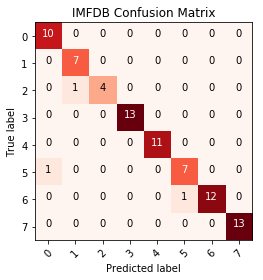

In [76]:
CM_title = ['IMFDB Confusion Matrix','CFW Confusion Matrix','YALE Confusion Matrix']
CM_X_data = [X_IMFDB_kLDA3D,X_CFW_resnet,X_YALE_resnet]
CM_Y_data = [y_IMFDB,y_CFW,y_YALE]

MyClassifier = Classifier()
MyClassifier.plot_confusion_matrix(ConfusionM_list[0], classes = np.unique(y_IMFDB),
                          title='IMFDB Confusion Matrix')

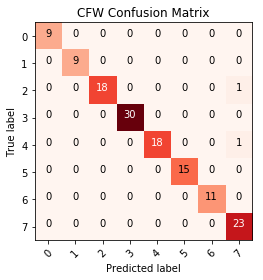

In [77]:
MyClassifier = Classifier()
MyClassifier.plot_confusion_matrix(ConfusionM_list[1], classes = np.unique(y_CFW),
                        title='CFW Confusion Matrix')

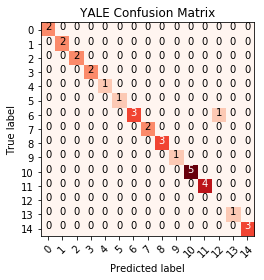

In [78]:
MyClassifier = Classifier()
MyClassifier.plot_confusion_matrix(ConfusionM_list[2], classes = np.unique(y_YALE),
                         title='YALE Confusion Matrix')


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

[]

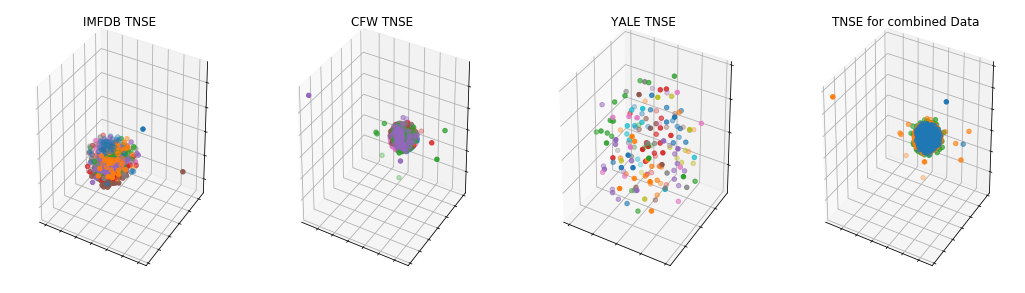

In [79]:
# Compute TSNE for different features and create a scatter plot

k = 3 # Number of components in TSNE

# Compute
X_IMFDB_TSNE = TSNE(n_components=k).fit_transform(X_IMFDB)
X_CFW_TSNE = TSNE(n_components=k).fit_transform(X_CFW)
X_YALE_TSNE = TSNE(n_components=k).fit_transform(X_YALE)


# Plot the representation in 2d/3d

fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(141, projection='3d')
ax.set_title('IMFDB TNSE')
for t in range(8):
    data = X_IMFDB_TSNE[np.where(y_IMFDB==t)]
    ax.scatter3D(data[:,0],data[:,1],data[:,2], cmap='red')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax = fig.add_subplot(142, projection='3d')
ax.set_title('CFW TNSE')
for t in range(8):
    data = X_CFW_TSNE[np.where(y_CFW==t)]
    ax.scatter3D(data[:,0],data[:,1],data[:,2], cmap='red')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax = fig.add_subplot(143, projection='3d')
ax.set_title('YALE TNSE')
for t in range(15):
    data = X_YALE_TSNE[np.where(y_YALE==t)]
    ax.scatter3D(data[:,0],data[:,1],data[:,2], cmap='red')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


X_TNSE = [X_IMFDB_TSNE,X_CFW_TSNE,X_YALE_TSNE]
ax = fig.add_subplot(144, projection='3d')
ax.set_title('TNSE for combined Data')
for t in range(3):
    data = X_TNSE[t]
    ax.scatter3D(data[:,0],data[:,1],data[:,2], cmap='red')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [80]:
class FaceVerification:
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def KNNClassify(self,X_train,y_train,X_test,y_test,k):
        y_train = y_train.reshape(y_train.shape[0],1)
        y_test = y_test.reshape(y_test.shape[0],1)
        knnmodel = KNeighborsClassifier(n_neighbors = k)
        knnmodel.fit(X_train, y_train)
        y_pred = knnmodel.predict(X_test)
        return y_pred
    
    def confusion_matrix(self,y_pred,y_test):
        cm = confusion_matrix(y_test, y_pred) 
        acc = accuracy_score(y_test, y_pred)
        precision,recall,f_score,_ = precision_recall_fscore_support(y_test, y_pred)
        
        return cm,acc,precision,recall,f_score
    
        

In [81]:
# Using KNN Classifier 
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# IMFDB Data : Create a train and validation split to train your classifier 
IMFDB_data = [X_IMFDB_PCA3D,X_IMFDB_kPCA3D,X_IMFDB_LDA3D,X_IMFDB_kLDA3D,X_IMFDB_resnet,X_IMFDB_vgg]
title_list = ['PCA','Kernal PCA','LDA','Kernal LDA','Resnet','VGG']
columns = ['Type','Reduced Dimension','Classification Error','Accuracy','F1 Score']
IMFDB_table_knn = pd.DataFrame(columns =columns)

for i in range(6):
    X_train, X_test, y_train, y_test = train_test_split(IMFDB_data[i], y_IMFDB, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = FaceVerification()
    y_pred = MyClassifier.KNNClassify(X_train,y_train,X_test,y_test,5)
    ConfusionM,acc,precision,recall,f_score = MyClassifier.confusion_matrix(y_pred,y_test)
    ClassError = 1-acc
    f_score_avg = np.average(f_score)
    row_data = pd.DataFrame([[title_list[i],data_shape,ClassError, acc,f_score_avg]],columns =columns)
    IMFDB_table_knn = IMFDB_table_knn.append(row_data)


# CFW Data : Create a train and validation split to train your classifier 
CFW_data = [X_CFW_PCA3D,X_CFW_kPCA3D,X_CFW_LDA3D,X_CFW_kLDA3D,X_CFW_resnet,X_CFW_vgg]
title_list = ['PCA','Kernal PCA','LDA','Kernal LDA','Resnet','VGG']
columns = ['Type','Reduced Dimension','Classification Error','Accuracy','F1 Score']
CFW_table_knn = pd.DataFrame(columns =columns)

for i in range(6):
    X_train, X_test, y_train, y_test = train_test_split(CFW_data[i], y_CFW, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = FaceVerification()
    y_pred = MyClassifier.KNNClassify(X_train,y_train,X_test,y_test,5)
    ConfusionM,acc,precision,recall,f_score = MyClassifier.confusion_matrix(y_pred,y_test)
    ClassError = 1-acc
    f_score_avg = np.average(f_score)
    row_data = pd.DataFrame([[title_list[i],data_shape,ClassError, acc,f_score_avg]],columns =columns)
    CFW_table_knn = CFW_table_knn.append(row_data)


# YALE Data: Create a train and validation split to train your classifier 
YALE_data = [X_YALE_PCA3D,X_YALE_kPCA3D,X_YALE_LDA3D,X_YALE_kLDA3D,X_YALE_resnet,X_YALE_vgg]
title_list = ['PCA','Kernal PCA','LDA','Kernal LDA','Resnet','VGG']
columns = ['Type','Reduced Dimension','Classification Error','Accuracy','F1 Score']
YALE_table_knn = pd.DataFrame(columns =columns)

for i in range(6):
    X_train, X_test, y_train, y_test = train_test_split(YALE_data[i], y_YALE, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = FaceVerification()
    y_pred = MyClassifier.KNNClassify(X_train,y_train,X_test,y_test,5)
    ConfusionM,acc,precision,recall,f_score = MyClassifier.confusion_matrix(y_pred,y_test)
    ClassError = 1-acc
    f_score_avg = np.average(f_score)
    row_data = pd.DataFrame([[title_list[i],data_shape,ClassError, acc,f_score_avg]],columns =columns)
    YALE_table_knn = YALE_table_knn.append(row_data)



C:\Users\prachysi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [82]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
print('**********************************************************')
print("Printing table for IMFDB data using KNN")
print('**********************************************************')
print(IMFDB_table_knn)
print('**********************************************************')
print("Printing table for CFW data using KNN")
print('**********************************************************')
print(CFW_table_knn)
print('**********************************************************')
print("Printing table for YALE data using KNN")
print('**********************************************************')
print(YALE_table_knn)


**********************************************************
Printing table for IMFDB data using KNN
**********************************************************
         Type Reduced Dimension  Classification Error  Accuracy  F1 Score
0         PCA         (320, 30)                0.3375    0.6625  0.658882
0  Kernal PCA         (320, 30)                0.3375    0.6625  0.656813
0         LDA          (320, 7)                0.0250    0.9750  0.958333
0  Kernal LDA          (320, 7)                0.0250    0.9750  0.958333
0      Resnet       (320, 2048)                0.0625    0.9375  0.935293
0         VGG       (320, 4096)                0.1125    0.8875  0.874352
**********************************************************
Printing table for CFW data using KNN
**********************************************************
         Type Reduced Dimension  Classification Error  Accuracy  F1 Score
0         PCA         (537, 40)              0.488889  0.511111  0.516874
0  Kernal PCA       

C:\Users\prachysi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


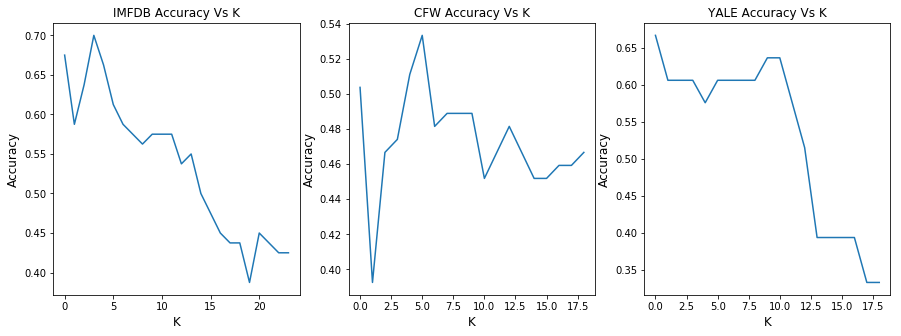

In [83]:
K_IMFDB_acc = []
K_CFW_acc = []
K_YALE_acc = []

for k in range(1,25):
    X_train, X_test, y_train, y_test = train_test_split(X_IMFDB_PCA3D, y_IMFDB, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = FaceVerification()
    y_pred = MyClassifier.KNNClassify(X_train,y_train,X_test,y_test,k)
    K_acc = accuracy_score(y_pred,y_test)
    K_IMFDB_acc.append(K_acc)
    
for k in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(X_CFW_PCA3D, y_CFW, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = FaceVerification()
    y_pred = MyClassifier.KNNClassify(X_train,y_train,X_test,y_test,k)
    K_acc = accuracy_score(y_pred,y_test)
    K_CFW_acc.append(K_acc)
    
for k in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(X_YALE_PCA3D, y_YALE, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = FaceVerification()
    y_pred = MyClassifier.KNNClassify(X_train,y_train,X_test,y_test,k)
    K_acc = accuracy_score(y_pred,y_test)
    K_YALE_acc.append(K_acc)

KNN_K_List = [K_IMFDB_acc,K_CFW_acc,K_YALE_acc]
KNN_K_Title = ['IMFDB Accuracy Vs K','CFW Accuracy Vs K','YALE Accuracy Vs K']
subplot_List = [131,132,133]

plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(subplot_List[i])
    plt.plot(KNN_K_List[i])
    plt.title(KNN_K_Title[i])
    plt.xlabel("K",fontsize=12)
    plt.ylabel("Accuracy",fontsize=12)



### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [84]:
# Load data
dir_path_CartoonVsReal = 'C:/Users/prachysi/Desktop/IIITH/Assignment2/SMAI2019_Assignment2_dataset/dataset/CartoonvsReal/'
image_list = []
y_list = []
CR_dict = {'Cartoon': 0,
    'Real': 1,}


for filename in sorted(os.listdir(dir_path_CartoonVsReal)):
    if filename.endswith(".png"):
        im = load_image(os.path.join(dir_path_CartoonVsReal,filename))
        y = filename.split('_')[1]
        result = y.startswith('00')
        if result is True:
            y_label = 0
        else:
            y_label = 1
        image_list.append(im)
        y_list.append(y_label)
    else:
        continue

image_listA = np.array(image_list)
y_listA = np.array(y_list)

print("Dataset shape:",image_listA.shape)

N,H,W = image_listA.shape[0:3]
C = 1 if opt['is_grayscale'] else image_listA.shape[3]
X_CartoonReal = image_listA.reshape((N,H*W*C))
y_CR = y_listA.reshape(y_listA.shape[0],1)

Dataset shape: (1072, 32, 32, 3)


In [85]:
# Define your features
X_CR_PCA3D , _ = get_pca(X_CartoonReal,30)
X_CR_kPCA3D , _ = get_kernel_pca(X_CartoonReal, 30,kernel='rbf')
X_CR_LDA3D = get_lda(X_CartoonReal,y_CR,30)
X_CR_kLDA3D = get_kernel_lda(X_CartoonReal,y_CR,30,kernel='rbf')


C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prachysi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [86]:
# Create your classifier
CR_data = [X_CR_PCA3D,X_CR_kPCA3D,X_CR_LDA3D,X_CR_kLDA3D]
title_list_CR = ['PCA','Kernal PCA','LDA','Kernal LDA']
columns = ['Type','Reduced Dimension','Classification Error','Accuracy','F1 Score']
CR_table = pd.DataFrame(data = None, columns =columns)

for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(CR_data[i], y_CR, test_size=0.20, random_state=42)
    data_shape = X_train.shape
    MyClassifier = Classifier()
    y_pred = MyClassifier.classify(X_train,y_train,X_test,y_test)
    ConfusionM,acc,precision,recall,f_score = MyClassifier.confusion_matrix(y_pred,y_test)
    ClassError = 1-acc
    f_score_avg = np.average(f_score)
    row_data = pd.DataFrame([[title_list_CR[i],data_shape,ClassError, acc,f_score_avg]],columns =columns)
    CR_table = CR_table.append(row_data)
print("Cartoon vs Real dataset Result")
print(CR_table)
# Validate your classifier

Cartoon vs Real dataset Result
         Type Reduced Dimension  Classification Error  Accuracy  F1 Score
0         PCA         (857, 30)              0.041860  0.958140  0.954854
0  Kernal PCA         (857, 30)              0.023256  0.976744  0.974635
0         LDA          (857, 1)              0.000000  1.000000  1.000000
0  Kernal LDA          (857, 1)              0.000000  1.000000  1.000000


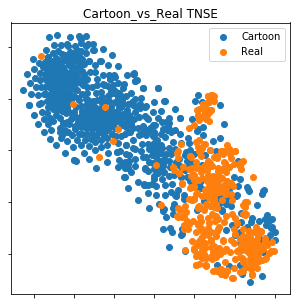

In [87]:
# Compute TSNE for different features and create a scatter plot

k = 2 # Number of components in TSNE
CR_Label = ['Cartoon','Real']
# Compute
X_CR_TSNE = TSNE(n_components=k).fit_transform(X_CartoonReal)

# Plot the representation in 2d

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.set_title('Cartoon_vs_Real TNSE')
for t in range(2):
    data = X_CR_TSNE[np.where(y_CR==t)[0]]
    ax.scatter(data[:,0],data[:,1], cmap='red',label = CR_Label[t])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.legend()